In [22]:
import dlgn
from data_gen import Args, data_gen_decision_tree 
import openml
import numpy as np
import dlgn, dlgn_vt, lcn,  tao, kernel, sdt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


SUITE_ID = 337
benchmark_suite = openml.study.get_suite(SUITE_ID) 

In [2]:
def get_task_size(id):
    task = openml.tasks.get_task(id)
    return task.get_X_and_y()[0].shape[1]
arr = benchmark_suite.tasks.copy()
arr.sort(key=lambda x: get_task_size(x))

/tmp/ipykernel_105467/3423270144.py:5: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  arr.sort(key=lambda x: get_task_size(x))
/home/sooraj/.local/lib/python3.12/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/tmp/ipykernel_105467/3423270144.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensu

In [52]:
electricity = openml.tasks.get_task(arr[3])
dataset = electricity.get_dataset()
X, y, _, _ = dataset.get_data(target=electricity.target_name)
np.random.seed(42)
rng = np.random.permutation(X.shape[0])
scaler = StandardScaler()



labels = y.to_numpy()
classes = np.unique(labels)
labels = np.where(labels == classes[0], 0, 1)
data_x = X.to_numpy()
data_x = scaler.fit_transform(data_x)
data_x, labels = data_x[rng], labels[rng]
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(data_x, labels)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
data_x = data_x[:, indices[:2]]

# data_x = data_x[:, np.array([0, 1])]

num_data = len(data_x)
num_vali = (num_data*9)//100
num_train= (num_data*7)//10
num_test = (num_data*21)//100
train_data = data_x[:num_train,:]
train_data_labels = labels[:num_train]

vali_data = data_x[num_train:num_train+num_vali,:]
vali_data_labels = labels[num_train:num_train+num_vali]

test_data = data_x[num_train+num_vali :,:]
test_data_labels = labels[num_train+num_vali :]

args = Args()
args.input_dim = data_x.shape[1]
args.lr = 0.001
args.numlayer = 5
args.numnodes = 50

/home/sooraj/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/sooraj/.local/lib/python3.12/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/home/sooraj/.local/lib/python3.12/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from 

In [53]:
dlgn_model = dlgn.trainDLGN(args)
dlgn_model.train(train_data, train_data_labels, vali_data, vali_data_labels, test_data, test_data_labels)

  0%|          | 0/2048 [00:00<?, ?it/s]

100%|██████████| 2048/2048 [04:33<00:00,  7.49it/s]

Setup:
Num neurons :  [2, 50, 50, 50, 50, 50, 50, 50, 1]
 Beta : 3.0
 lr : 0.001
[0.7, 0.6918228268623352, 0.6580281853675842, 0.5424022853374482, 0.5033804833889007, 0.4959727942943573, 0.4927130103111267, 0.49089365601539614, 0.48955123126506805, 0.4883360654115677, 0.4872651547193527, 0.48582239747047423, 0.484413281083107, 0.4832593560218811, 0.48229269683361053, 0.4814181387424469, 0.4804691642522812, 0.4478751510381699, 0.43178397715091704, 0.418761870265007, 0.40449207127094267, 0.40437833666801454, 0.39975915253162386]
==========Best validated model=============
Train error= 2904
Train loss =  tensor(0.4026, grad_fn=<NllLossBackward0>)
Num_train_data= 14443
Test error= 884
Num_test_data= 4334
DLGN Test accuracy= 79.6031379787725


79.6031379787725

In [40]:
def visualize(X, color):
    # c1 = X
    c1 = X[color == 0]
    c2 = X[color == 1]
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.scatter(c1[:, 0], c1[:, 1], s=0.1)
    plt.scatter(c2[:, 0], c2[:, 1], s=0.1)

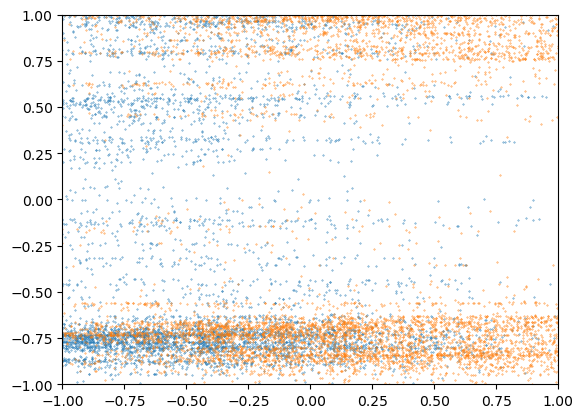

In [41]:
visualize(data_x, labels)

In [11]:
np.min(data_x[:, 1])

-1.5235244604857479

In [54]:
def plot_decision_boundary(model):
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    grid = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(grid)
    # print(pred)
    pred = pred.reshape(xx.shape)
    pred = (np.sign(pred) + 1)//2
    plt.contourf(xx, yy, pred, alpha=0.3)

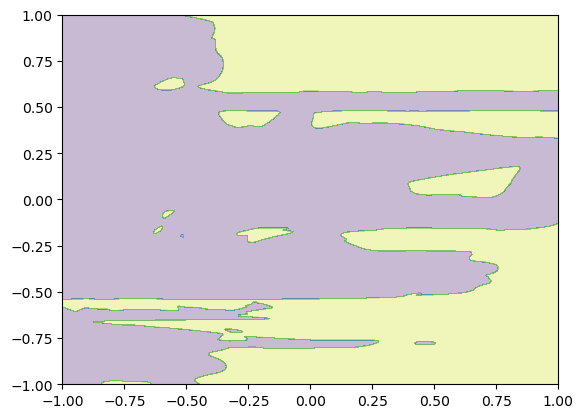

In [55]:
plot_decision_boundary(dlgn_model)

0.7731887401938163


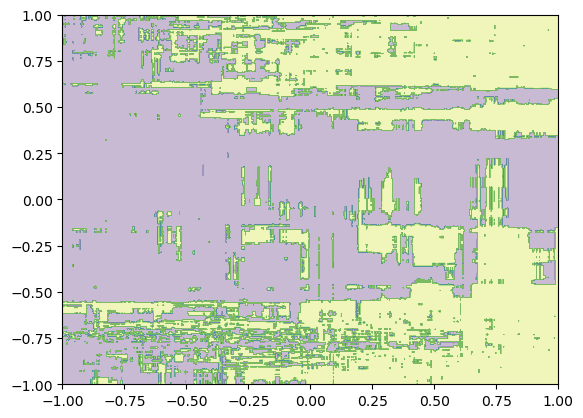

In [51]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf = XGBClassifier()
clf.fit(train_data, train_data_labels)
print(clf.score(test_data, test_data_labels))
plot_decision_boundary(clf)